In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from torch.nn import CrossEntropyLoss
from torch.nn import Conv2d, MaxPool2d, Linear, ReLU, Softmax, Module, BatchNorm2d, Dropout, LeakyReLU, Sequential
from torch.nn.init import kaiming_uniform_, constant_, xavier_uniform_
from torchvision import transforms, datasets
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
from torch.optim import SGD
import sys
from torch import save, load, cuda
from torch import device
import os
import torch.nn.functional as F
import math
import time
import torch.optim 
import torchvision.models as models


In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# Defining as global the device to use (by default CPU).
device = torch.device("cuda")

In [ ]:
!pip install torchviz

In [ ]:

# Are the top five scored labels accurate?
def top5_accuracy_img(predicted, labels):
    # print("predicted: ", predicted)
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    # print("pred_vals: ", pred_vals)
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    # print("true_vals: ", true_vals)
    return (pred_vals == true_vals).sum(dim = 1) / 5.0


In [ ]:
def train_model(batch_size, 
                seq_length,
                n_epochs, 
                model, 
                cost_function, 
                optimizer,
                train_loader,
                val_loader):

  # Move the model and cost function to GPU (if needed).
  model = model.to(device)
  cost_function = cost_function.to(device)

  # Keep track of best accuracy so far.
  best_accuracy = 0 
  liveloss = PlotLosses()

  # Main for loop of SGD.
  for epoch in range(0, n_epochs):
      logs = {}

      # initialize control variables.
      correct = 0
      cumulative_loss = 0
      n_samples = 0

      # Set the model in training mode.
      model.train()

      # Sample a batch on each iteration.
      for (batch_id, (xb, yb)) in enumerate(train_loader):
          model.zero_grad()

          if xb.shape[0] < batch_size:
            continue
          # Move (x,y) data to GPU (if so desired).
          xb = xb.to(device)
          # print(xb.shape)

          in_CNN = torch.zeros((seq_length*xb.shape[0], 3, 224, 224))
          cnt_in_CNN = 0
          for i in range(xb.shape[0]):
            for j in range(seq_length):
              in_CNN[cnt_in_CNN] = xb[i][:,:,j*224:(j+1)*224]
              cnt_in_CNN += 1

          # print(in_CNN.shape)

          x = in_CNN.to(device)
          yb = yb.to(device)

          # Compute predictions.
          predicted = model(x)
          # print(xb.shape, yb.shape, predicted.shape)

          # Compute loss.
          loss = cost_function(predicted, yb)
          cumulative_loss += loss.item()

          # Count how many correct in batch.
          predicted_ = predicted.detach().softmax(dim = 1)
          max_vals, max_ids = predicted_.max(dim = 1)
          correct += (max_ids == yb).sum().cpu().item()
          n_samples += xb.size(0)

          # Compute gradients (autograd).
          loss.backward()

          # Run one basic training step of SGD.
          optimizer.step()

          # Keep track of loss and accuracy for the plot.
          n_batches = 1 + batch_id 
          logs['loss'] = cumulative_loss / n_batches
          logs['accuracy'] = correct / n_samples
      # print(f'train accuracy: {correct / n_samples} and loss: {loss}')
      
      # initialize control variables.
      correct = 0
      cumulative_loss = 0
      n_samples = 0

      # Set the model in evaluation mode.
      model.eval()

      # No need to keep track of gradients for this part.
      with torch.no_grad():
          # Run the model on the validation set to keep track of accuracy there.
          for (batch_id, (xb, yb)) in enumerate(train_loader):
              if xb.shape[0] < batch_size:
                continue
              # Move (x,y) data to GPU (if so desired).
              xb = xb.to(device)
              # print(xb.shape)

              in_CNN = torch.zeros((seq_length*xb.shape[0], 3, 224, 224))
              cnt_in_CNN = 0
              for i in range(xb.shape[0]):
                for j in range(seq_length):
                  in_CNN[cnt_in_CNN] = xb[i][:,:,j*224:(j+1)*224]
                  cnt_in_CNN += 1

              # print(in_CNN.shape)

              x = in_CNN.to(device)
              yb = yb.to(device)

              # Compute predictions.
              predicted = model(x)
              # print(xb.shape, yb.shape, predicted.shape)

              # Compute loss.
              loss = cost_function(predicted, yb)
              cumulative_loss += loss.item()

              # Count how many correct in batch.
              predicted_ = predicted.detach().softmax(dim = 1)
              max_vals, max_ids = predicted_.max(dim = 1)
              correct += (max_ids == yb).sum().cpu().item()
              n_samples += xb.size(0)

              # Keep track of loss and accuracy for the plot.
              n_batches = 1 + batch_id 
              logs['val_loss'] = cumulative_loss / n_batches
              logs['val_accuracy'] = correct / n_samples

      # Save the parameters for the best accuracy on the validation set so far.
      if logs['val_accuracy'] > best_accuracy:
          best_accuracy = logs['val_accuracy']
          torch.save(model.state_dict(), '/content/drive/MyDrive/Elaheh/Deep_Learning_Project/best_model_so_far.pth')

      # Update the plot with new logging information.
      liveloss.update(logs)
      liveloss.send()
   

In [ ]:
class CNN_LSTM(nn.Module):
    #We should have batch_size*seq_length batches everytime. So, the input is (batch_size*seq_length, C=3, H, W). 
    #After extracting features from model_CNN the output shape is (batch_size*seq_length, C_new, H_new, W_new).
    #We reshape the output to (batch_size, seq_length, -1) for passing to model_RNN
    def __init__(self, input_size=2048*1*1, hidden_size=4, num_layers=2, seq_length=20, video_batch_size=16, num_classes=50):
        self.seq_length = seq_length
        self.video_batch_size = video_batch_size
        super(CNN_LSTM, self).__init__()

        self.model_CNN = models.resnext101_32x8d(pretrained=True)
        for param in self.model_CNN.parameters():
            param.requires_grad = False
        
        # x -> (batch_size, seq_length, input_size) --> seq_length=hidden_size
        # nn.LSTM(input_size, hidden_size, num_layers) --> hidden_size=seq_length, num_layers=how many LSTM layer we want to stack together
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

        #since we used bidirectional=True in LSTM so the num_layers should be twice or num_layers*2
        self.h0 = torch.zeros(num_layers*2, video_batch_size, hidden_size).to(device=device)
        self.c0 = torch.zeros(num_layers*2, video_batch_size, hidden_size).to(device=device)

        #if bidirectional=True the output of LSTM will be hidden_size*2
        self.fc1 = nn.Linear(hidden_size*2, 512)
        self.drp1 = nn.Dropout(0.5)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        constant_(self.fc1.bias, 0)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.drp2 = nn.Dropout(0.4)
        kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        constant_(self.fc2.bias, 0)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(256, num_classes)
        kaiming_uniform_(self.fc3.weight)
        constant_(self.fc2.bias, 0)
        
    def forward(self, x):
        # with torch.no_grad():
        self.CNN_Feature_Out = {}
        self.model_CNN.avgpool.register_forward_hook(self.get_activation('Feature_Out'))
        self.model_CNN(x)
        out_CNN = self.CNN_Feature_Out['Feature_Out']
        # print(out_CNN.shape)
        out_CNN = out_CNN.reshape(self.video_batch_size, self.seq_length, -1)
        # print(out_CNN.shape)
        out_lstm, _ = self.lstm(out_CNN, (self.h0,self.c0))
        #out_lstm -> (batch_size, seq_length, hidden_size) -> we only need the last output in our sequence not middle outputs -> out_lstm[:, -1, :]

        x = self.drp1(self.act1(self.fc1(out_lstm[:, -1, :])))
        x = self.drp2(self.act2(self.fc2(x)))
        x = self.fc3(x)

        return(x)
        # return(out_lstm)
    
    def get_activation(self, name):
        def hook(model, input, output):
            self.CNN_Feature_Out[name] = output.detach()
        return hook

In [ ]:
#output of avgpool = 2048*1*1 and output of layer4 is 2048*7*7
input_size=2048*1*1
hidden_size=512
num_layers=2 #how many lstm stack together

ImageBatchSize = 120
seq_length = 30 #seq_length=hidden_size
video_batch_size = int(ImageBatchSize/seq_length)

model = CNN_LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, seq_length=seq_length, video_batch_size=video_batch_size, num_classes=50)
model = model.to(device)
x = torch.rand(ImageBatchSize, 3, 224, 224)
x = x.cuda()
out = model(x)
print(out.shape)

torch.Size([4, 50])


In [ ]:
from torchviz import make_dot
make_dot(out, params=dict(list(model.named_parameters()))).render("lstm-rnn", format="pdf")

'lstm-rnn.pdf'

We should concatenate seq_length of inputs together as a one input and set a label to it. 

1) When we want to pass the input to CNN_LSTM we need to break it to the original image size. For example, if we have 16 videos and each video has 20 images so totally we have 320 images which should pass to CNN_LSTM. 

2) Then, we will reshape the output of self.model_CNN before passing it to LSTM.

In [ ]:
# !cp -r "/content/drive/MyDrive/Elaheh/Deep_Learning_Project/Dataset_Video/test/" "/content/drive/MyDrive/Elaheh/Deep_Learning_Project/Dataset_tmp/test"

In [ ]:
# Parse input options
dataset_path    = "/content/drive/MyDrive/Elaheh/Deep_Learning_Project/Dataset_Vid/"
outfile_path    = "/content/drive/MyDrive/Elaheh/Deep_Learning_Project/Data/"
model_checkpt   = "/content/drive/MyDrive/Elaheh/Deep_Learning_Project/Data/"

data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(60),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

path_data = os.path.join(dataset_path, "train")
train_dataset = datasets.ImageFolder(root = path_data,
                                           transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=video_batch_size, shuffle=True,
                                             num_workers=4)

valid_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

path_data = os.path.join(dataset_path, "test") #"test"
test_dataset = datasets.ImageFolder(root = path_data,
                                           transform=valid_transform)
val_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=video_batch_size, shuffle=True,
                                             num_workers=4)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# # Load the model parameters for the one that achieved the best val accuracy.
# model.load_state_dict(torch.load('/content/drive/MyDrive/Elaheh/Deep_Learning_Project/best_model_so_far.pth')) 

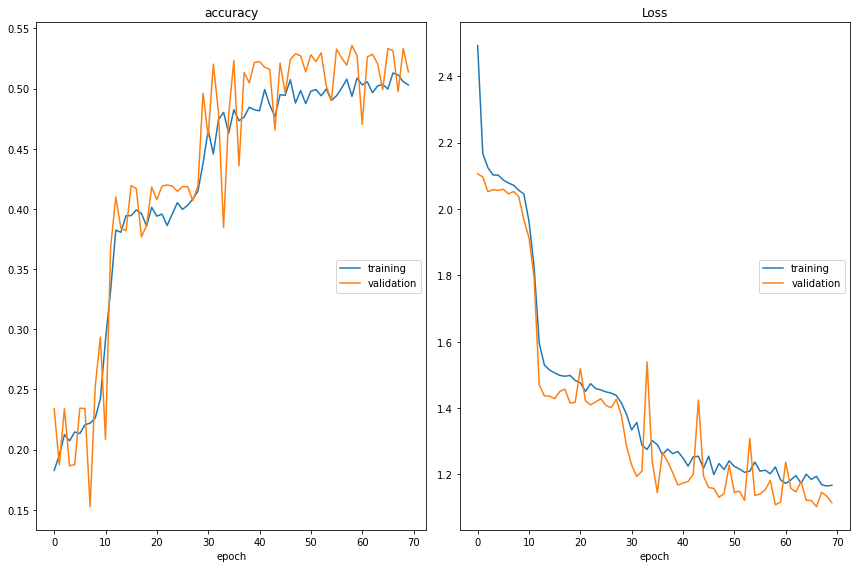

accuracy
	training         	 (min:    0.183, max:    0.513, cur:    0.503)
	validation       	 (min:    0.153, max:    0.536, cur:    0.514)
Loss
	training         	 (min:    1.165, max:    2.493, cur:    1.167)
	validation       	 (min:    1.103, max:    2.106, cur:    1.115)


In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

n_epochs = 200
learningRate = 1e-3
optimizer = SGD(model.parameters(),lr=learningRate, momentum=0.9, weight_decay=5e-4, nesterov=True)
cost_function = CrossEntropyLoss()

train_model(video_batch_size, seq_length, n_epochs, 
            model, cost_function, optimizer,
            train_loader, val_loader);